# 05. Inference Demo

This notebook demonstrates the **Inference Pipeline** in action.
It simulates a real-world scenario where the model processes individual windows of raw sensor data to predict stress levels.

**Objective:**
1.  Load a trained model artifact (Deep Learning or Logistic Regression) using the `StressPredictor`.
2.  Sample random windows (Stress vs. Baseline) from the validation set.
3.  Visualize the raw signal "texture" (Instance Normalized) which the model "sees".
4.  Display the Model's Prediction, Confidence, and Ground Truth side-by-side.

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastapi.testclient import TestClient
from src.api.app import app

# Add project root
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.models.predict import StressPredictor
from src.config import load_config, PROJECT_ROOT
from src.visualization.plots import set_plot_style
from src.visualization.plots import visualize_inference

# Set plot style
set_plot_style()
config = load_config()

print("Setup Complete.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup Complete.


## 1. Select and Load Model
Choose between `'deep'` (ResNet-1D) or `'logistic'` (Baseline) model types. 
The notebook will automatically find the latest trained artifact in the `reports/` directory.

In [23]:
# Configuration
MODEL_TYPE = 'deep' # Options: 'deep', 'logistic'
# MODEL_TYPE = 'logistic' 

reports_dir = PROJECT_ROOT / "reports"
run_pattern = f"{MODEL_TYPE}_loso_*"
runs = sorted(list(reports_dir.glob(run_pattern)))

if not runs:
    raise FileNotFoundError(f"No runs found for pattern {run_pattern}. Please run the training pipeline first.")

latest_run = runs[-1]
print(f"Loading Artifact: {latest_run.name}")

# Initialize Predictor
predictor = StressPredictor(latest_run)
print(f"Predictor Ready: {predictor.model_type.upper()}")

Loading Artifact: deep_loso_CHEST_20260118_162043
Predictor Ready: DEEP


## 2. Load Validation Data
We load the full processed dataset to pick random samples. 
In a production scenario, this data would come live from the device.

In [24]:
data_path = PROJECT_ROOT / "data" / "processed" / "windows.parquet"
df = pd.read_parquet(data_path)

# Filter for Binary Labels only (1=Baseline, 2=Stress)
df = df[df['label'].isin([1, 2])].copy()
# Remap for display
label_map = {1: 'Baseline', 2: 'Stress'}
df['label_str'] = df['label'].map(label_map)

print(f"Data Loaded: {len(df)} windows available.")

Data Loaded: 919 windows available.


## 3. Run Live Inference
Run this cell repeatedly to see different examples!

--- CASE 1: STRESS SAMPLE ---


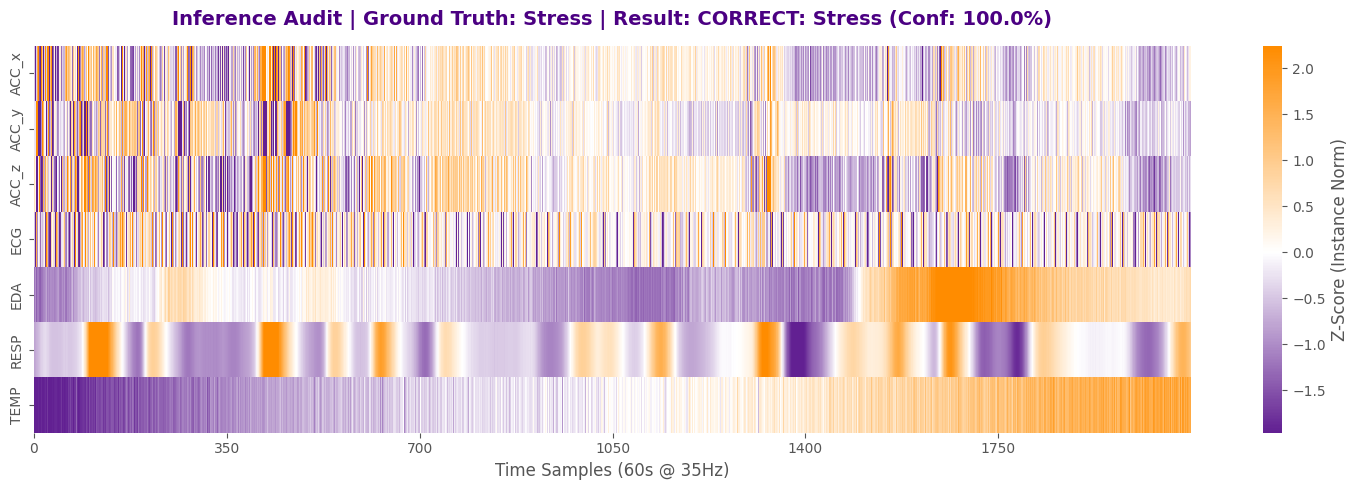

--- CASE 2: BASELINE SAMPLE ---


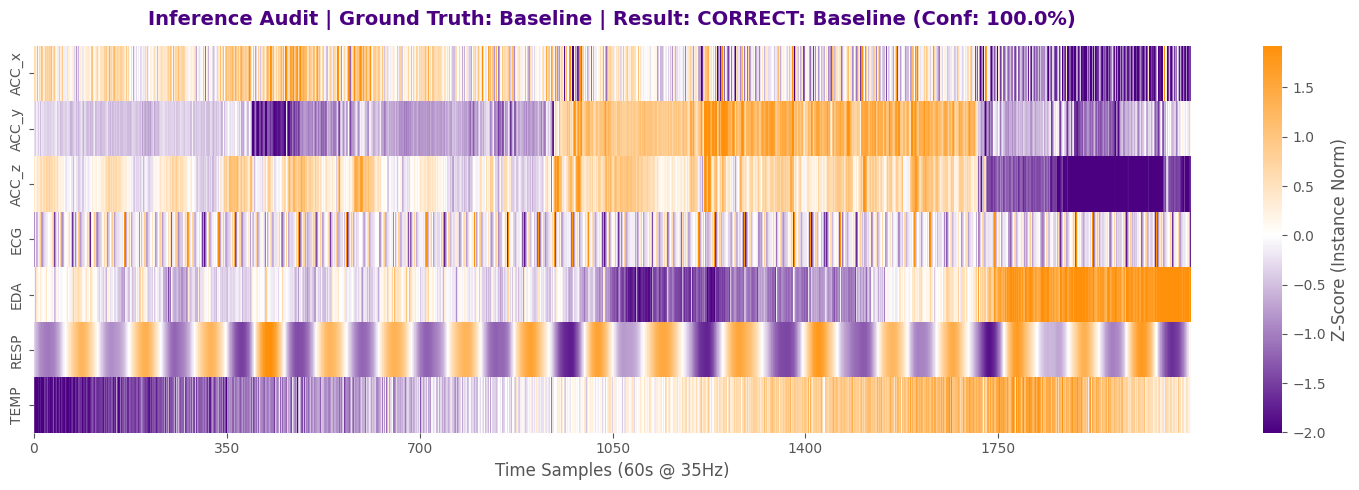

In [25]:
# Sample 1 Random Stress and 1 Random Baseline Window
stress_sample = df[df['label'] == 2].sample(1).iloc[0]
baseline_sample = df[df['label'] == 1].sample(1).iloc[0]

print("--- CASE 1: STRESS SAMPLE ---")
_ = visualize_inference(stress_sample, predictor)
plt.show()

print("--- CASE 2: BASELINE SAMPLE ---")
_ = visualize_inference(baseline_sample, predictor)
plt.show()

## 4. API Endpoint Verification
Demonstrates how to use the FastAPI endpoint directly from Python using `TestClient`.
This simulates a REST API call as if the server were running.

In [ ]:
# 4. Initialize Test Client
with TestClient(app) as client:
    
    # Prepare Payload from the loaded 'stress_sample'
    # We convert the numpy arrays in the Series to simple lists for JSON serialization
    payload = {
        "ACC_x": stress_sample['ACC_x'].tolist(),
        "ACC_y": stress_sample['ACC_y'].tolist(),
        "ACC_z": stress_sample['ACC_z'].tolist(),
        "ECG": stress_sample['ECG'].tolist(),
        "EDA": stress_sample['EDA'].tolist(),
        "RESP": stress_sample['RESP'].tolist(),
        "TEMP": stress_sample['TEMP'].tolist()
    }

    # Send Request
    print("Sending request to /predict (stress sample)...")
    response = client.post("/predict", json=payload)

    # Parse Response
    if response.status_code == 200:
        res_json = response.json()
        print("\n--- API Response ---")
        print(f"Status: {res_json['status']}")
        print(f"Prediction: {res_json['prediction']}")
        print(f"Confidence: {res_json['confidence']:.4f}")
        print(f"Probabilities: {res_json['probabilities']}")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

2026-01-18 17:21:20,441 - src.api.app - INFO - Loading Model Artifact: deep_loso_CHEST_20260118_162043
2026-01-18 17:21:20,456 - src.api.app - INFO - StressPredictor initialized successfully (deep).
Sending request to /predict (stress sample)...

--- API Response ---
Status: Success
Prediction: Stress
Confidence: 0.9996
Probabilities: {'Baseline': 0.00043561268830671906, 'Stress': 0.9995643496513367}
